# Oficina de dados na disciplina de Modelagem Informacional

## Oficina de dados de vacinação de covid com serviços da nuvem AWS

### Desafio individual

Ler os dados públicos de vacinação da covid-19 do seu estado e montar um indicador de percentual da população de vacinados por município. A projeção de população por município está no site do IBGE.

### Recursos necessários

Espaço de armazenamento e de processamento na nuvem da AWS (já disponível).
Dados de vacinação do DATASUS (já disponível).
Dados populacionais do IBGE.

### Entrega

- Procure problemas de qualidade nos seus dados e responda as perguntas abaixo:
  - Existem registros repetidos?
  - Existem pessoas que tomaram mais de 3 doses da vacina?
  - A quantidade de vacinados na primeira dose é superior ou igual a quantidade na segunda?
  - Descubra como fazer um JOIN entre as duas tabelas carregadas e monte uma tabela listando o nome do município, o respectivo código do IBGE, e o percentual da população vacinada por município.

#### Bônus

Apresentar e explicar qualquer visualização interessante dos seus dados. Se quiser, pode exportar e fazer no power BI.

### Orientações gerais - fase 1

Use a região padrão Norte de Virgínia.
Sempre que tiver um campo perguntando sobre "IAM Role" escolha "LabRole".

1. Iniciar o seu lab na sua conta AWS Academy no curso Learner Lab.
2. Criar um bucket no S3 chamado cache-athena-<<número aleatório>>.
3. Criar um bucket no S3 chamado oficina-<<número aleatório>>. Criar subpastas oficina-<<número aleatório>>/opendatasus/mg/, oficina-<<número aleatório>>/opendatasus/zonabruta/covid-vac-mg-1
4. Criar um notebook no SageMaker com todas as opções padrão. Abrir este arquivo com o motor "conda_pytorch_p310".
5. Fazer o download de um arquivo de vacinação da parte1 de MG https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao
6. Carregar no bucket S3 oficina-<<número aleatório>>.
7. Usar o Glue para usar o CSV como uma tabela no formato AVRO no Athena.
8. Brincar com análises básicas.
9. Fazer download https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html?=&t=downloads
10. Carregar no S3 como uma nova tabela, seguindo passos similares aos da vacinação.

### Ver espaço livre em disco

Você vai precisar desse espaço para manipular os arquivos antes de subir ao S3. Vemos 48G livres.

In [1]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        1.9G     0  1.9G   0% /dev
tmpfs           1.9G     0  1.9G   0% /dev/shm
tmpfs           1.9G  640K  1.9G   1% /run
tmpfs           1.9G     0  1.9G   0% /sys/fs/cgroup
/dev/nvme0n1p1  135G   88G   48G  65% /
/dev/nvme1n1    4.8G   48K  4.6G   1% /home/ec2-user/SageMaker
tmpfs           386M     0  386M   0% /run/user/1002
tmpfs           386M     0  386M   0% /run/user/1001
tmpfs           386M     0  386M   0% /run/user/1000
tmpfs           386M     0  386M   0% /run/user/0


#### Download da parte 1 de MG no opendatasus

Abra o portal https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao e procure o arquivo, pois a URL muda de padrão diariamente.
Abaixo:
1. download para o "/tmp"
2. validação "ls..."
3. ver o cabeçalho do arquivo. Vemos um arquivo delimitado por aspas e separado por ';'
4. copiar arquivo para bucket oficina-<<número aleatório>>/opendatasus/mg/

In [2]:
!curl https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIPNI/COVID/uf/uf%3DMG/part-00000-cc054ea2-ae24-4ccc-9d1b-03b3ba17e431.c000.csv -o /tmp/covid-vac-mg-1.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5535M  100 5535M    0     0  24.0M      0  0:03:50  0:03:50 --:--:-- 23.3M    0     0  23.0M      0  0:03:59  0:01:34  0:02:25 19.5M3:13  0:00:38 22.6M8  0:00:23 25.1M


In [4]:
!ls -ltr /tmp/covid*

-rw-rw-r-- 1 ec2-user ec2-user 5804705067 May  4 20:11 /tmp/covid-vac-mg-1.csv


In [5]:
!head -n 3 /tmp/covid-vac-mg-1.csv

"document_id";"paciente_id";"paciente_idade";"paciente_dataNascimento";"paciente_enumSexoBiologico";"paciente_racaCor_codigo";"paciente_racaCor_valor";"paciente_endereco_coIbgeMunicipio";"paciente_endereco_coPais";"paciente_endereco_nmMunicipio";"paciente_endereco_nmPais";"paciente_endereco_uf";"paciente_endereco_cep";"paciente_nacionalidade_enumNacionalidade";"estabelecimento_valor";"estabelecimento_razaoSocial";"estalecimento_noFantasia";"estabelecimento_municipio_codigo";"estabelecimento_municipio_nome";"estabelecimento_uf";"vacina_grupoAtendimento_codigo";"vacina_grupoAtendimento_nome";"vacina_categoria_codigo";"vacina_categoria_nome";"vacina_lote";"vacina_fabricante_nome";"vacina_fabricante_referencia";"vacina_dataAplicacao";"vacina_descricao_dose";"vacina_codigo";"vacina_nome";"sistema_origem"
"1bafafc8-614e-4457-bcda-5bd01dbc2553-i0b0";"da4854a2e5c463a2b3208ee56ec06fafe6a9e02fb6721359dae86f03dfa36358";"19";"2002-05-16";"F";"04";"AMARELA";"317070";"10";"VARGINHA";"BRASIL";"MG";"3

In [6]:
file_name = "/tmp/covid-vac-mg-1.csv"

import boto3

s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'oficina-0973', 'opendatasus/mg/covid-vac-mg-1.csv')

### Orientações gerais - fase 2

#### Catalogar no Glue

1. Abrir AWS Glue
2. Criar database oficina
3. Criar tabela oficina.forma-vazia-covid-vac-mg-1 em s3://oficina-0973/opendatasus/zonabruta/covid-vac-mg-1 e colar o esquema json abaixo, escolher o formato 'avro'
4. Novo visual ETL, origem = S3 bucket apontando para oficina-0973/opendatasus/mg/covid-vac-mg-1.csv
5. Ainda no ETL, destino = AWS Glue data catalog apontando para a tabela vazia criada em (3), rodar o job, certifique-e de escolher "Update schema and add new partitions"
6. Criar um novo crawler para ler o local s3://oficina-0973/opendatasus/zonabruta/covid-vac-mg-1

Você terá uma nova tabela "oficina"."covid-vac-mg-1".

##### Tabela de vacinação em formato json:

[
  {
    "Name": "document_id",
    "Type": "string"
  },
  {
    "Name": "paciente_id",
    "Type": "string"
  },
  {
    "Name": "paciente_idade",
    "Type": "bigint"
  },
  {
    "Name": "paciente_datanascimento",
    "Type": "string"
  },
  {
    "Name": "paciente_enumsexobiologico",
    "Type": "string"
  },
  {
    "Name": "paciente_racacor_codigo",
    "Type": "bigint"
  },
  {
    "Name": "paciente_racacor_valor",
    "Type": "string"
  },
  {
    "Name": "paciente_endereco_coibgemunicipio",
    "Type": "bigint"
  },
  {
    "Name": "paciente_endereco_copais",
    "Type": "bigint"
  },
  {
    "Name": "paciente_endereco_nmmunicipio",
    "Type": "string"
  },
  {
    "Name": "paciente_endereco_nmpais",
    "Type": "string"
  },
  {
    "Name": "paciente_endereco_uf",
    "Type": "string"
  },
  {
    "Name": "paciente_endereco_cep",
    "Type": "bigint"
  },
  {
    "Name": "paciente_nacionalidade_enumnacionalidade",
    "Type": "string"
  },
  {
    "Name": "estabelecimento_valor",
    "Type": "bigint"
  },
  {
    "Name": "estabelecimento_razaosocial",
    "Type": "string"
  },
  {
    "Name": "estalecimento_nofantasia",
    "Type": "string"
  },
  {
    "Name": "estabelecimento_municipio_codigo",
    "Type": "bigint"
  },
  {
    "Name": "estabelecimento_municipio_nome",
    "Type": "string"
  },
  {
    "Name": "estabelecimento_uf",
    "Type": "string"
  },
  {
    "Name": "vacina_grupoatendimento_codigo",
    "Type": "bigint"
  },
  {
    "Name": "vacina_grupoatendimento_nome",
    "Type": "string"
  },
  {
    "Name": "vacina_categoria_codigo",
    "Type": "bigint"
  },
  {
    "Name": "vacina_categoria_nome",
    "Type": "string"
  },
  {
    "Name": "vacina_lote",
    "Type": "string"
  },
  {
    "Name": "vacina_fabricante_nome",
    "Type": "string"
  },
  {
    "Name": "vacina_fabricante_referencia",
    "Type": "string"
  },
  {
    "Name": "vacina_dataaplicacao",
    "Type": "string"
  },
  {
    "Name": "vacina_descricao_dose",
    "Type": "string"
  },
  {
    "Name": "vacina_codigo",
    "Type": "bigint"
  },
  {
    "Name": "vacina_nome",
    "Type": "string"
  },
  {
    "Name": "sistema_origem",
    "Type": "string"
  }
]

#### O DDL da tabela avro, se precisar

```sql
CREATE EXTERNAL TABLE `covid-vac-mg-1`(
  `document_id` string COMMENT 'from deserializer', 
  `paciente_id` string COMMENT 'from deserializer', 
  `paciente_idade` string COMMENT 'from deserializer', 
  `paciente_datanascimento` string COMMENT 'from deserializer', 
  `paciente_enumsexobiologico` string COMMENT 'from deserializer', 
  `paciente_racacor_codigo` string COMMENT 'from deserializer', 
  `paciente_racacor_valor` string COMMENT 'from deserializer', 
  `paciente_endereco_coibgemunicipio` string COMMENT 'from deserializer', 
  `paciente_endereco_copais` string COMMENT 'from deserializer', 
  `paciente_endereco_nmmunicipio` string COMMENT 'from deserializer', 
  `paciente_endereco_nmpais` string COMMENT 'from deserializer', 
  `paciente_endereco_uf` string COMMENT 'from deserializer', 
  `paciente_endereco_cep` string COMMENT 'from deserializer', 
  `paciente_nacionalidade_enumnacionalidade` string COMMENT 'from deserializer', 
  `estabelecimento_valor` string COMMENT 'from deserializer', 
  `estabelecimento_razaosocial` string COMMENT 'from deserializer', 
  `estalecimento_nofantasia` string COMMENT 'from deserializer', 
  `estabelecimento_municipio_codigo` string COMMENT 'from deserializer', 
  `estabelecimento_municipio_nome` string COMMENT 'from deserializer', 
  `estabelecimento_uf` string COMMENT 'from deserializer', 
  `vacina_grupoatendimento_codigo` string COMMENT 'from deserializer', 
  `vacina_grupoatendimento_nome` string COMMENT 'from deserializer', 
  `vacina_categoria_codigo` string COMMENT 'from deserializer', 
  `vacina_categoria_nome` string COMMENT 'from deserializer', 
  `vacina_lote` string COMMENT 'from deserializer', 
  `vacina_fabricante_nome` string COMMENT 'from deserializer', 
  `vacina_fabricante_referencia` string COMMENT 'from deserializer', 
  `vacina_dataaplicacao` string COMMENT 'from deserializer', 
  `vacina_descricao_dose` string COMMENT 'from deserializer', 
  `vacina_codigo` string COMMENT 'from deserializer', 
  `vacina_nome` string COMMENT 'from deserializer', 
  `sistema_origem` string COMMENT 'from deserializer')
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.serde2.avro.AvroSerDe' 
WITH SERDEPROPERTIES ( 
  'avro.schema.literal'='{\"type\":\"record\",\"name\":\"DynamicRecord\",\"namespace\":\"root\",\"fields\":[{\"name\":\"document_id\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_id\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_idade\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_dataNascimento\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_enumSexoBiologico\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_racaCor_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_racaCor_valor\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_coIbgeMunicipio\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_coPais\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_nmMunicipio\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_nmPais\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_uf\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_cep\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_nacionalidade_enumNacionalidade\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_valor\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_razaoSocial\",\"type\":[\"string\",\"null\"]},{\"name\":\"estalecimento_noFantasia\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_municipio_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_municipio_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_uf\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_grupoAtendimento_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_grupoAtendimento_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_categoria_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_categoria_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_lote\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_fabricante_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_fabricante_referencia\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_dataAplicacao\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_descricao_dose\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"sistema_origem\",\"type\":[\"string\",\"null\"]}]}') 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.avro.AvroContainerInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.avro.AvroContainerOutputFormat'
LOCATION
  's3://oficina-0973/opendatasus/zonabruta/'
TBLPROPERTIES (
  'CrawlerSchemaDeserializerVersion'='1.0', 
  'CrawlerSchemaSerializerVersion'='1.0', 
  'UPDATED_BY_CRAWLER'='arruma-covid-vac', 
  'averageRecordSize'='455', 
  'avro.schema.literal'='{\"type\":\"record\",\"name\":\"DynamicRecord\",\"namespace\":\"root\",\"fields\":[{\"name\":\"document_id\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_id\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_idade\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_dataNascimento\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_enumSexoBiologico\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_racaCor_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_racaCor_valor\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_coIbgeMunicipio\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_coPais\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_nmMunicipio\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_nmPais\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_uf\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_endereco_cep\",\"type\":[\"string\",\"null\"]},{\"name\":\"paciente_nacionalidade_enumNacionalidade\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_valor\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_razaoSocial\",\"type\":[\"string\",\"null\"]},{\"name\":\"estalecimento_noFantasia\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_municipio_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_municipio_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"estabelecimento_uf\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_grupoAtendimento_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_grupoAtendimento_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_categoria_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_categoria_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_lote\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_fabricante_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_fabricante_referencia\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_dataAplicacao\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_descricao_dose\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_codigo\",\"type\":[\"string\",\"null\"]},{\"name\":\"vacina_nome\",\"type\":[\"string\",\"null\"]},{\"name\":\"sistema_origem\",\"type\":[\"string\",\"null\"]}]}', 
  'classification'='avro', 
  'compressionType'='none', 
  'objectCount'='87', 
  'recordCount'='11878008', 
  'sizeKey'='5438235286', 
  'typeOfData'='file')
```

### Orientações gerais - fase 3

#### No athena - testar select e limpar lixos

Fazer análises

Instale a biblioteca do athena para ler os dados de lá através de instruções SQL.

In [7]:
import sys
!{sys.executable} -m pip install PyAthena

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 8.9 MB/s eta 0:00:00


Ler e contar os dados da tabela. Você irá ver um aviso para usar o "SQLAlchemy", favor ignorar.

In [8]:
from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://cache-athena-0963/',
               region_name='us-east-1')

total = pd.read_sql("SELECT count(*) FROM AwsDataCatalog.oficina.zonabruta;", conn)
total

/tmp/ipykernel_6352/972068178.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total = pd.read_sql("SELECT count(*) FROM AwsDataCatalog.oficina.zonabruta;", conn)


,_col0
0,11896099


Quanto % da população se vacinou no mesmo município?

In [9]:
total_mesmo_municipio = pd.read_sql("select sum(count) from (Select  count(*) as count,  paciente_endereco_nmmunicipio, estabelecimento_municipio_nome from AwsDataCatalog.oficina.zonabruta where paciente_endereco_nmmunicipio = estabelecimento_municipio_nome group by  paciente_endereco_nmmunicipio,  estabelecimento_municipio_nome) as s0;",conn)
pct_mesmo_municipio = total_mesmo_municipio * 100 / total
pct_mesmo_municipio

/tmp/ipykernel_6352/1170666978.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_mesmo_municipio = pd.read_sql("select sum(count) from (Select  count(*) as count,  paciente_endereco_nmmunicipio, estabelecimento_municipio_nome from AwsDataCatalog.oficina.zonabruta where paciente_endereco_nmmunicipio = estabelecimento_municipio_nome group by  paciente_endereco_nmmunicipio,  estabelecimento_municipio_nome) as s0;",conn)


,_col0
0,85.043416


Quais as vacinas mais usadas para pessoas que vacinaram em município diferente da moradia?

In [10]:
preferencia_vacinas = pd.read_sql("select count(*) as count, vacina_fabricante_nome, paciente_idade  from AwsDataCatalog.oficina.zonabruta where paciente_endereco_nmmunicipio != estabelecimento_municipio_nome group by vacina_fabricante_nome, paciente_idade;",conn)
preferencia_vacinas.head()

/tmp/ipykernel_6352/638843546.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preferencia_vacinas = pd.read_sql("select count(*) as count, vacina_fabricante_nome, paciente_idade  from AwsDataCatalog.oficina.zonabruta where paciente_endereco_nmmunicipio != estabelecimento_municipio_nome group by vacina_fabricante_nome, paciente_idade;",conn)


,count,vacina_fabricante_nome,paciente_idade
0,14662,PFIZER,36
1,1470,PFIZER,84
2,3237,Pendente Identificação,6
3,353,BUTANTAN,20
4,360,ASTRAZENECA,45


Estatísticas básicas da contagem de vacinas por tipo e idade que foram feitas fora do município de moradia.

In [11]:
preferencia_vacinas.describe()

,count
count,939.000000
mean,1894.834931
std,3625.000052
min,1.000000
25%,7.500000
50%,232.000000
75%,1714.000000
max,19003.000000


Vamos fazer alguns gráficos?

In [12]:
import matplotlib.pyplot as plt

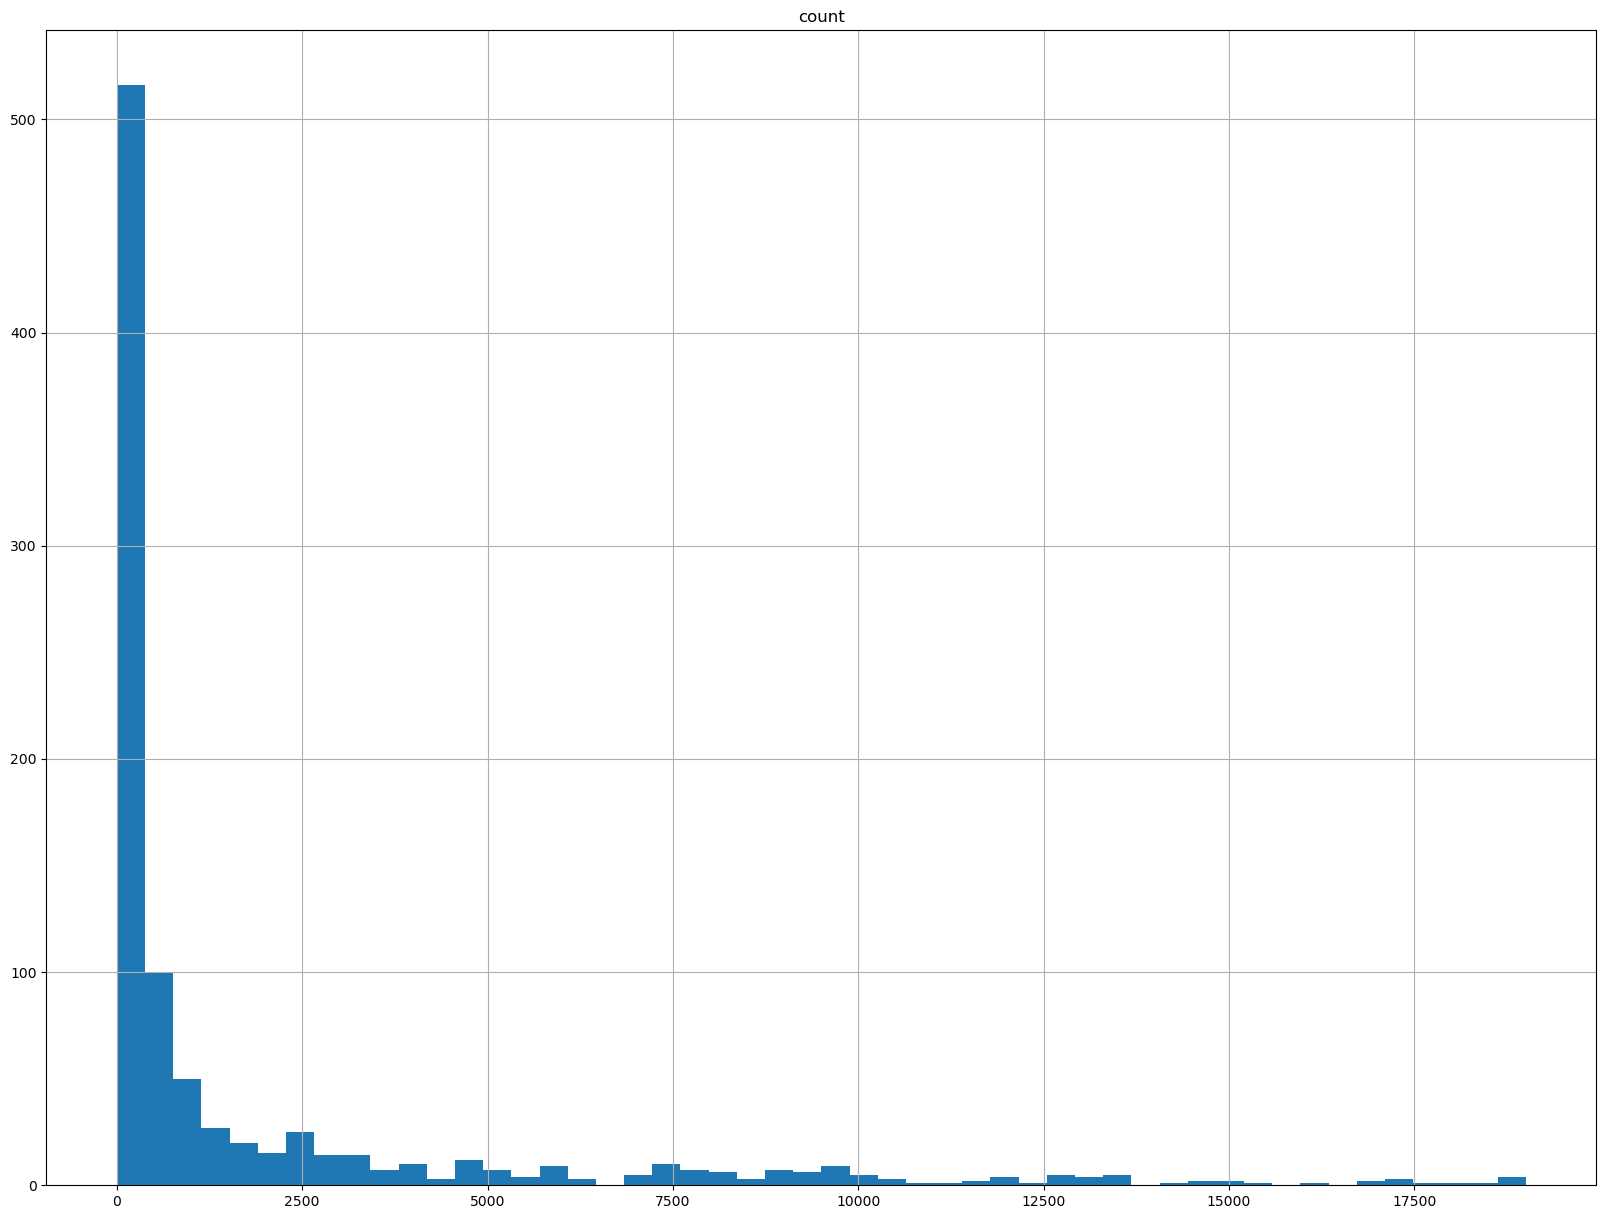

In [13]:
#hitograma dos dados, do count
preferencia_vacinas.hist(bins=50, figsize=(20,15))
plt.show()

In [14]:
#colunas do dataset
preferencia_vacinas.columns

Index(['count', 'vacina_fabricante_nome', 'paciente_idade'], dtype='object')

In [15]:
#Quantos valores únicos tem a variáveis vacina_fabricante_nome?
preferencia_vacinas['vacina_fabricante_nome'].unique()

array(['PFIZER', 'Pendente Identificação', 'BUTANTAN', 'ASTRAZENECA',
       'ASTRAZENECA/FIOCRUZ', 'Pendente Identifica??o',
       'SINOVAC/BUTANTAN', 'SINOVAC', 'JANSSEN', 'PFIZER - PEDIÁTRICA',
       'PFIZER - PEDI?TRICA', 'PFIZER - PEDIÁTRICA MENOR DE 5 ANOS',
       'FUNDACAO OSWALDO CRUZ',
       'PFIZER MANUFACTURING BELGIUM NV - BELGICA',
       'JANSSEN PHARMACEUTICA NV', 'SINOVAC LIFE SCIENCES CO., LTD'],
      dtype=object)

Removeremos a coluna "idade"

In [16]:
preferencia_vacinas.drop(['paciente_idade'],axis=1,inplace=True)

In [17]:
preferencia_vacinas

,count,vacina_fabricante_nome
0,14662,PFIZER
1,1470,PFIZER
2,3237,Pendente Identificação
3,353,BUTANTAN
4,360,ASTRAZENECA
...,...,...
934,4844,Pendente Identificação
935,790,SINOVAC/BUTANTAN
936,30,ASTRAZENECA
937,22,JANSSEN


/tmp/ipykernel_6352/527238173.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(names, rotation=45)


Text(0.5, 0.98, 'Quantidade de aplicações por tipo de vacinas aplicadas fora do município de residência')

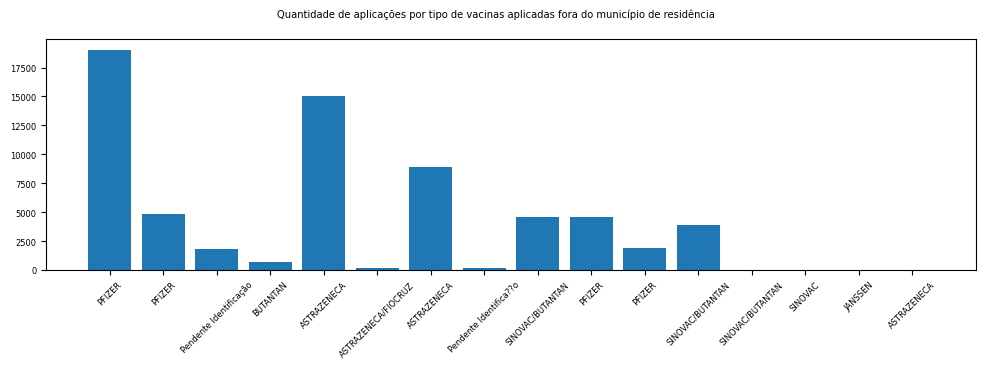

In [18]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html

plt.rcParams.update({'font.size': 6})
names = preferencia_vacinas['vacina_fabricante_nome']
values = preferencia_vacinas['count']

fig, axs = plt.subplots(1, 1, figsize=(12, 3))
axs.bar(names, values)
axs.set_xticklabels(names, rotation=45)
fig.suptitle('Quantidade de aplicações por tipo de vacinas aplicadas fora do município de residência')

In [19]:
preferencia_vacinas_mesmo_municipio = pd.read_sql("select count(*) as count, vacina_fabricante_nome, paciente_idade  from AwsDataCatalog.oficina.zonabruta  where paciente_endereco_nmmunicipio = estabelecimento_municipio_nome group by vacina_fabricante_nome, paciente_idade;",conn)

/tmp/ipykernel_6352/849843829.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preferencia_vacinas_mesmo_municipio = pd.read_sql("select count(*) as count, vacina_fabricante_nome, paciente_idade  from AwsDataCatalog.oficina.zonabruta  where paciente_endereco_nmmunicipio = estabelecimento_municipio_nome group by vacina_fabricante_nome, paciente_idade;",conn)


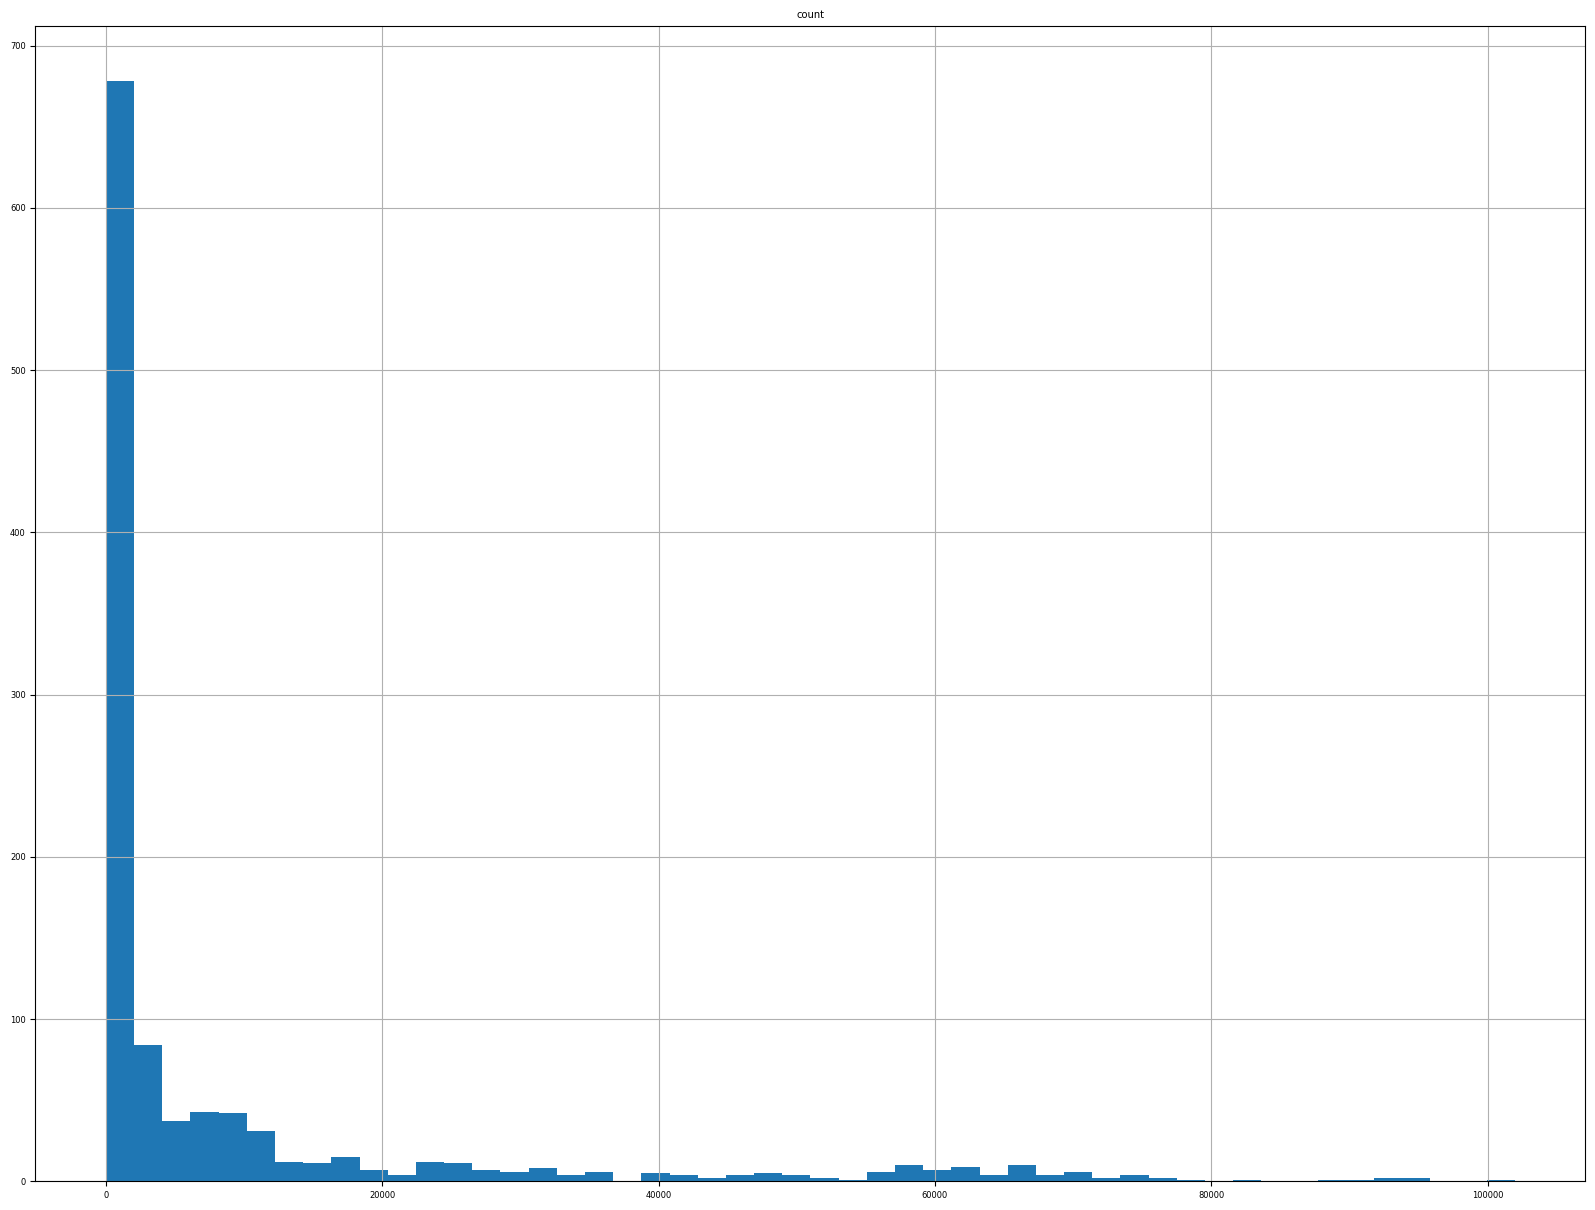

In [20]:
#hitograma dos dados
preferencia_vacinas_mesmo_municipio.hist(bins=50, figsize=(20,15))
plt.show()

/tmp/ipykernel_6352/1956884279.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(names, rotation=45)


Text(0.5, 0.98, 'Quantidade de aplicações por tipo de vacinas aplicadas no mesmo município de residência')

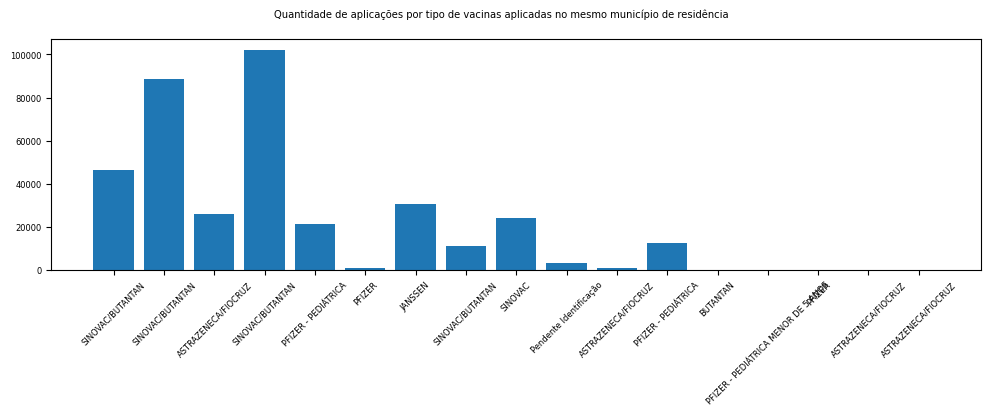

In [21]:
plt.rcParams.update({'font.size': 6})
names = preferencia_vacinas_mesmo_municipio['vacina_fabricante_nome']
values = preferencia_vacinas_mesmo_municipio['count']

fig, axs = plt.subplots(1, 1, figsize=(12, 3))
axs.bar(names, values)
axs.set_xticklabels(names, rotation=45)
fig.suptitle('Quantidade de aplicações por tipo de vacinas aplicadas no mesmo município de residência')

In [23]:
maiores = preferencia_vacinas_mesmo_municipio[preferencia_vacinas_mesmo_municipio['count']>80000]
maiores

,count,vacina_fabricante_nome,paciente_idade
133,101982,PFIZER,12
242,91842,PFIZER,13
261,94614,PFIZER,15
560,82878,ASTRAZENECA/FIOCRUZ,61
581,91194,PFIZER,14
800,95132,PFIZER,16
925,93203,PFIZER,17
1104,88481,ASTRAZENECA/FIOCRUZ,60


ETL resultante do visual ETL no Glue, se precisar.

```python
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

args = getResolvedOptions(sys.argv, ['JOB_NAME'])
sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)
job.init(args['JOB_NAME'], args)

# Script generated for node Amazon S3
AmazonS3_node1714854917742 = glueContext.create_dynamic_frame.from_options(format_options={"quoteChar": "\"", "withHeader": True, "separator": ";", "optimizePerformance": False}, connection_type="s3", format="csv", connection_options={"paths": ["s3://oficina-0973/opendatasus/mg/covid-vac-mg-1.csv"], "recurse": True}, transformation_ctx="AmazonS3_node1714854917742")

# Script generated for node AWS Glue Data Catalog
AWSGlueDataCatalog_node1714855054906 = glueContext.write_dynamic_frame.from_catalog(frame=AmazonS3_node1714854917742, database="oficina", table_name="covid-vac-mg-1", additional_options={"enableUpdateCatalog": True, "updateBehavior": "UPDATE_IN_DATABASE"}, transformation_ctx="AWSGlueDataCatalog_node1714855054906")

job.commit()
```